# <center>**Facial Emotion Recognition**</center>



# Context of the Project:
The [**RAF-DB (Real-World Affective Face Database)**](http://https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset) is a dataset that contains images of human faces labeled with seven emotional expressions: **happy** , **angry** , **sad** , **fear** , **disgust** , **surprise**  and **neutral** . These emotions are critical for various applications in human-computer interaction, psychology, and affective computing.

Facial emotion recognition (FER) is a subfield of computer vision that focuses on identifying human emotions from facial expressions. Recognizing emotions from faces has practical applications in fields such as:

* **Customer service:** Analyzing customer satisfaction in real-time.
* **Security:** Identifying suspicious or threatening individuals.
* **Healthcare:** Monitoring emotional states in patients, especially those with mental health conditions.
* **Human-robot interaction:** Improving communication between humans and robots.

The challenge in this project is the imbalance in the classes, as some emotions are more prevalent than others, which can affect the performance of models trained on such data.

# Objective of the Project:

The main objective of this notebook is to classify the facial expressions from the RAF-DB dataset into seven categories based on the emotions they represent. Specifically, the objectives include:

1.  **Preprocess the data:** This involves loading, resizing, and normalizing images while addressing class imbalance (e.g., some emotions may be underrepresented in the dataset).

2. **Build CNN Model:** 
    * **CNN (Convolutional Neural Network) :** A deep learning model that can automatically learn features from images and will be evaluated for its ability to classify emotions.
    

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">data understanding</p>

In [2]:
import os
import cv2
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer,LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import roc_curve, auc

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from keras.backend import clear_session
import gc


In [3]:
# Load the labels CSV files
train_labels = pd.read_csv(r'C:\Users\Probook\Desktop\FER_RAF_DATASET\train_labels.csv')
test_labels = pd.read_csv(r'C:\Users\Probook\Desktop\FER_RAF_DATASET\test_labels.csv')

# Display the first few rows of the train labels to check the structure
print(train_labels.head())

classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']


label_map = {label: (idx+1) for idx, label in enumerate(classes)}

print(label_map)

                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5
{'surprise': 1, 'fear': 2, 'disgust': 3, 'happy': 4, 'sad': 5, 'angry': 6, 'neutral': 7}


In [4]:
# Function to load images and labels from the directory
def load_data(dataset_dir, label_map):
    images = []
    labels = []
    
    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))  # +1 because folder names start from '1'
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(idx)
    
    return np.array(images), np.array(labels)

# Load train and test datasets
train_images, train_labels = load_data(r'C:\Users\Probook\Desktop\FER_RAF_DATASET\DATASET\train', label_map)
test_images, test_labels = load_data(r'C:\Users\Probook\Desktop\FER_RAF_DATASET\DATASET\test', label_map)
print(train_images.shape)
print(test_images.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

(12271, 100, 100, 3)
(3068, 100, 100, 3)


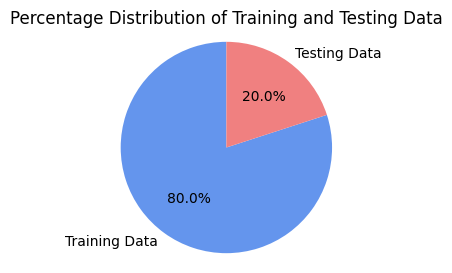

In [36]:
# Calculate the total number of images
total_images = len(train_images) + len(test_images)

# Calculate percentages
train_percentage = (len(train_images) / total_images) * 100
test_percentage = (len(test_images) / total_images) * 100

# Data for pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  
plt.show()


train_label_counts  Counter({4: 4772, 7: 2524, 5: 1982, 1: 1290, 3: 717, 6: 705, 2: 281})
test_counts [329, 74, 160, 1185, 478, 162, 680]


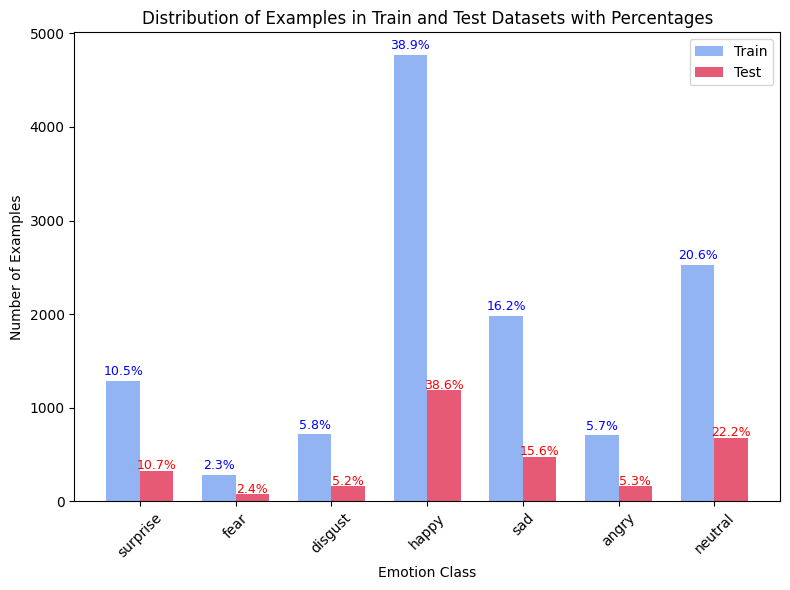

In [37]:
# Count the distribution of classes in train and test datasets
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)
print('train_label_counts ',train_label_counts)
# Convert to sorted lists for plotting
train_classes = sorted(train_label_counts.keys())
train_counts = [train_label_counts[cls] for cls in train_classes]

test_classes = sorted(test_label_counts.keys())
test_counts = [test_label_counts[cls] for cls in test_classes]
print('test_counts',test_counts)
# Calculate the total number of examples in train and test datasets
total_train = sum(train_counts)
total_test = sum(test_counts)

# Calculate percentages for train and test datasets
train_percentages = [(count / total_train) * 100 for count in train_counts]
test_percentages = [(count / total_test) * 100 for count in test_counts]

# Plot the distribution with percentages
plt.figure(figsize=(8, 6))
x = range(len(classes))
bar_width = 0.35

plt.bar(x, train_counts, width=bar_width, label="Train", alpha=0.7, color="cornflowerblue")
plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label="Test", alpha=0.7, color="crimson")

# Annotate percentages on bars
for i, (train_count, test_count) in enumerate(zip(train_counts, test_counts)):
    plt.text(i, train_count + 0.005 * total_train, f"{train_percentages[i]:.1f}%", ha='center', color="blue", fontsize=9)
    plt.text(i + bar_width, test_count + 0.005 * total_test, f"{test_percentages[i]:.1f}%", ha='center', color="red", fontsize=9)

# Add labels and title
plt.xticks([p + bar_width / 2 for p in x], classes, rotation=45)
plt.xlabel("Emotion Class")
plt.ylabel("Number of Examples")
plt.title("Distribution of Examples in Train and Test Datasets with Percentages")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

> The dataset shows a clear class imbalance, with **Happy** being the dominant class (39,9%) and **Fear** and **Angry** being underrepresented (2,3% and 5,7%). This imbalance may lead the model to favor the majority class, causing poor performance for minority classes. The distribution is consistent across train and test sets, but techniques like class weighting, oversampling, or data augmentation are needed to address this imbalance and improve model performance.

In [5]:
# Combine the train and test datasets into the same variables
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)

# Display the shapes to confirm
print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)



> To simplify the preprocessing steps, the training and testing datasets are merged into a single dataset.
> This is achieved by **concatenating** the images (train_images and test_images) and their corresponding labels (train_labels and test_labels) along the first axis, creating unified variables for further processing.
> 
> This combined dataset will allow for unified data augmentation and preprocessing steps before splitting it again for model training and evaluation. The shapes of the resulting arrays are displayed to verify the merge."


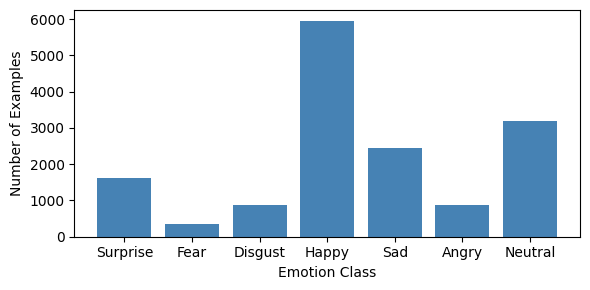

In [39]:
# Count the distribution of classes in the resampled train dataset
train_label_counts_resampled = Counter(Y_train)
    
# Convert to sorted lists for plotting
train_classes_resampled = sorted(train_label_counts_resampled.keys())
train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]
# Plot the distribution
plt.figure(figsize=(6, 3))
x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']
    
# Bar plot for the resampled distribution
plt.bar(x_labels, train_counts_resampled, color="steelblue")
    
# Add labels and title
plt.xlabel("Emotion Class")
plt.ylabel("Number of Examples")
plt.title('')
plt.tight_layout()
    
# Show the plot
plt.show()

In [6]:
# Shuffle X_train and Y_train
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

# Display the shapes to confirm the data is shuffled
print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)


> To ensure the training data is presented to the model in a random order, we shuffle the **X_train** and **Y_train** datasets using a fixed random state for reproducibility. This step helps prevent the model from learning any unintended patterns from the data ordering, improving the overall training process. 

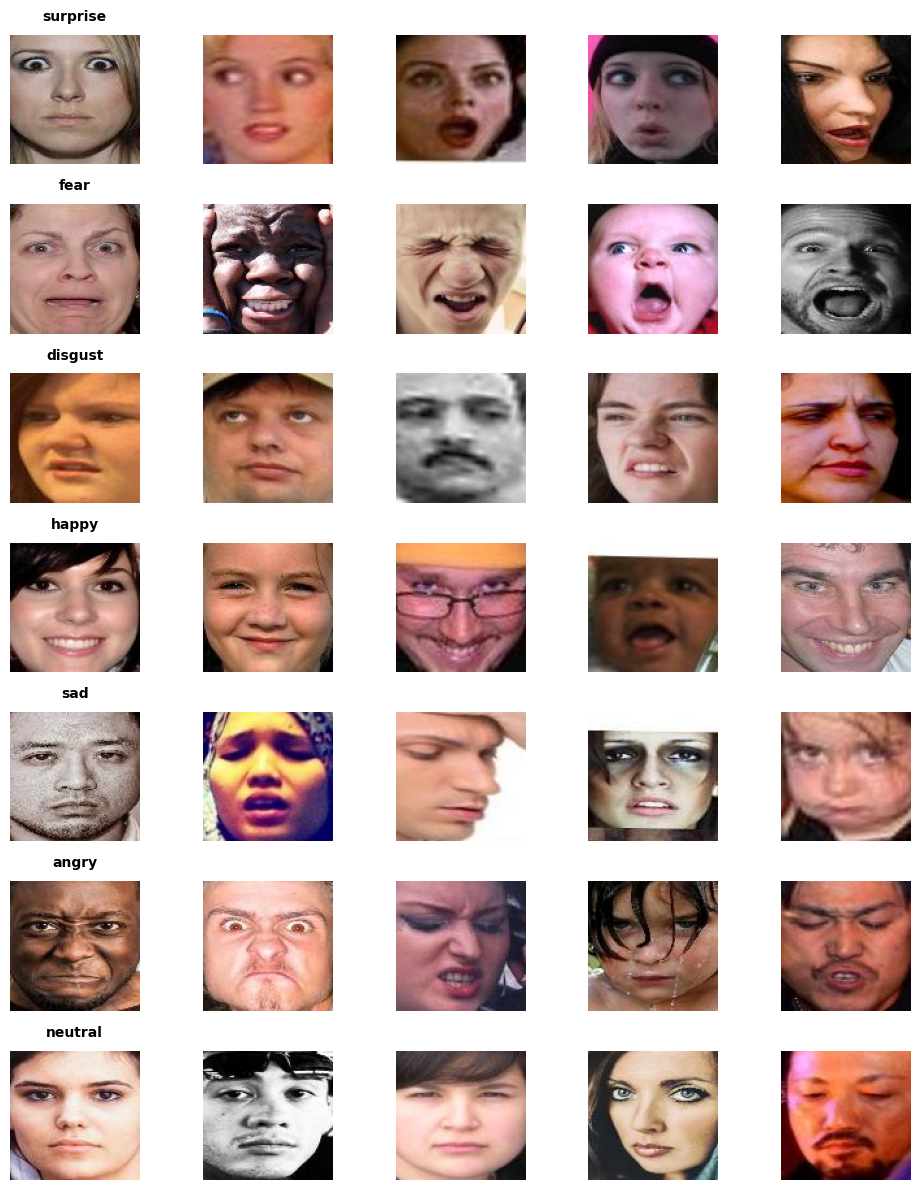

In [41]:
def show_examples(train_images, train_labels, labels, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 12))
    
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(train_labels) if label == i+1]
        selected_indices = np.random.choice(class_indices, num_examples, replace=False)
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        # Display the random images for the current class
        for j, idx in enumerate(selected_indices):
            img = train_images[idx]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images for each class
show_examples(X_train, Y_train, classes)

In [42]:
# most frequent image sizes :
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Count occurrences for each size
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Sort shapes by count
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# show most frequent size
print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (100, 100, 3): 15339


> The most frequent image shape in the training dataset is **(100, 100, 3)**, with **12,271** images in this resolution. Since the majority of the dataset already has a consistent size of **100x100 pixels** with three color channels (RGB), there is no need to resize the images. Maintaining their original dimensions avoids unnecessary computational overhead and preserves the quality and features of the data. This consistency simplifies preprocessing and ensures the model receives inputs in their native resolution, which can lead to better feature extraction and improved model performance.

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">data preparation</p>



**1. Oversampling**

> In this notebook, we address class **imbalance** by applying oversampling techniques. First, we **reduce** the size of the **'happy'** class to a target count using random sampling. Then, we **augment** the classes with fewer samples by generating additional images through data augmentation techniques such as rotation, translation, zooming, and horizontal flipping. This ensures a balanced distribution of classes, making the model training more robust and improving its performance on underrepresented classes. The final dataset distribution is visualized after both the reduction and augmentation processes to confirm the effectiveness of these techniques.

In [7]:
# Function to plot the class distribution
def plot_class_distribution(y, title):
    # Count the distribution of classes in the resampled train dataset
    train_label_counts_resampled = Counter(y)
    
    # Convert to sorted lists for plotting
    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]
    
    # Plot the distribution
    plt.figure(figsize=(6, 3))
    x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']
    
    # Bar plot for the resampled distribution
    plt.bar(x_labels, train_counts_resampled, color="steelblue")
    
    # Add labels and title
    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

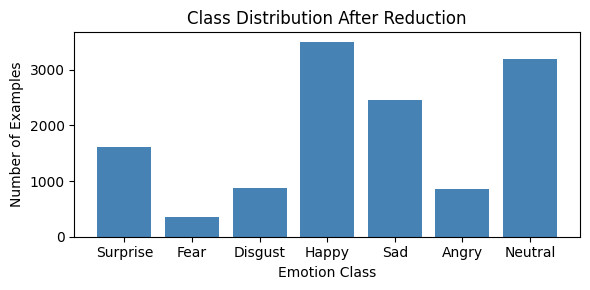

In [8]:
# Function to reduce the size of a specific class in the dataset
def reduce_class(X, y, target_class, target_size):
    # Separate the target class
    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]
    
    # Randomly sample the target class to the desired size
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)
    
    # Combine the reduced class with the other classes
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]
    
    return X_reduced, y_reduced

target_class = 4  # The 'happy' class
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)
# Plot the new distribution after reduction
plot_class_distribution(y_train_reduced, "Class Distribution After Reduction")

Class 1: 1619 samples, generating 1881 more.
Class 2: 355 samples, generating 3145 more.
Class 3: 877 samples, generating 2623 more.
Class 5: 2460 samples, generating 1040 more.
Class 6: 867 samples, generating 2633 more.
Class 7: 3204 samples, generating 296 more.


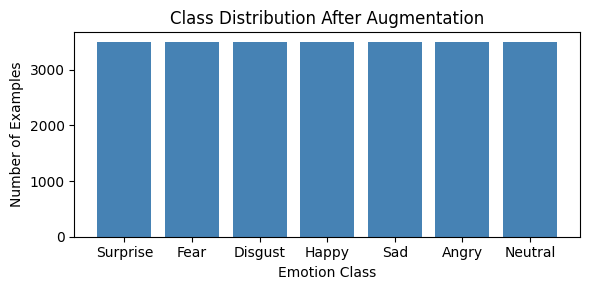

In [9]:
def augment_classes(images, labels, target_counts):
    # Initialize the image augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=10,             # Random rotation between -10 to 10 degrees
        width_shift_range=0.1,         # Random horizontal shift
        height_shift_range=0.1,        # Random vertical shift
        zoom_range=0.1,                # Random zoom
        vertical_flip=False,           # No vertical flip
        horizontal_flip=True,          # Random horizontal flip
        channel_shift_range=50.0,      # Random change in channel values
        fill_mode='nearest'            # Fill in new pixels using the nearest value
    )

    augmented_images = images.copy()  # Copy images to keep originals intact
    augmented_labels = labels.copy()  # Same for labels

    # For each class, increase the number of samples if needed
    for target_class, target_count in target_counts.items():
        # Filter images and labels for the current target class
        class_images = images[labels == target_class]
        class_labels = labels[labels == target_class]
        # Calculate how many new samples we need
        augment_count = target_count - len(class_images)

        if augment_count > 0:
            print(f'Class {target_class}: {len(class_images)} samples, generating {augment_count} more.')

            # Prepare lists to hold augmented images and labels
            class_images_augmented = []
            class_labels_augmented = []

            # Generate augmented samples iteratively
            for batch in datagen.flow(class_images, batch_size=1, seed=42):
                aug_image = batch[0].astype(np.uint8)
                class_images_augmented.append(aug_image)
                class_labels_augmented.append(target_class)
                
                # Stop when we've generated enough
                if len(class_images_augmented) >= augment_count:
                    break
            
            # Add the new samples to the original dataset
            augmented_images = np.vstack((augmented_images, np.array(class_images_augmented)))
            augmented_labels = np.hstack((augmented_labels, np.array(class_labels_augmented)))

    return augmented_images, augmented_labels

# Example usage
target_counts = {1: 3500, 2: 3500, 3: 3500, 5: 3500, 6: 3500, 7: 3500}  # Desired number of samples per class
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced, target_counts)

# Visualize the class distribution after augmentation
plot_class_distribution(y_train_augmented, "Class Distribution After Augmentation")


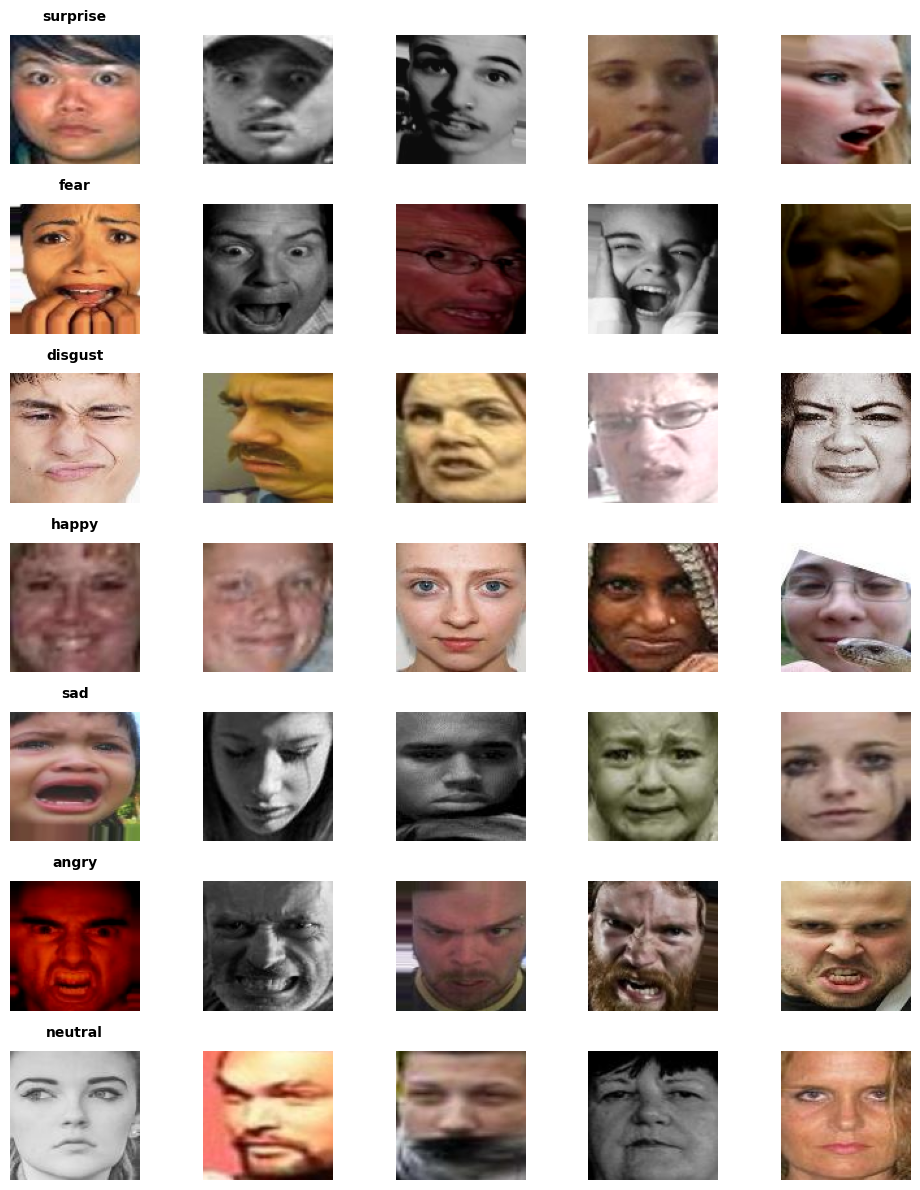

In [46]:
# Show sample images for each class
show_examples(X_train_augmented, y_train_augmented, classes)

**Split**



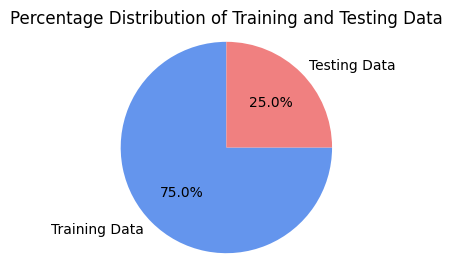

In [10]:
# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_train_augmented, 
                                                    y_train_augmented, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    random_state=42)

# Calculate the total number of images
total_images = len(X_train) + len(X_test)

# Calculate percentages
train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100

# Data for pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  
plt.show()


> The dataset is split into training and testing sets, with 75% allocated for training and 25% for testing, using the train_test_split function. TThis separation is crucial for evaluating the model's generalization ability on unseen data.

In [10]:
from sklearn.model_selection import train_test_split

# Split training data into new train and validation sets (e.g., 10% validation)
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=42, stratify=Y_train
)


**Normalize the images**
> To standardize the pixel values and ensure consistent input for the model, the image data is normalized by scaling the pixel values to a **range of [0, 1]**. This is achieved by dividing the pixel values by 255, the maximum pixel value for an 8-bit image. Both the training and testing images are normalized using this approach to facilitate better model performance and faster convergence during training.

In [11]:
def normalize_images(images):
    # Normalize pixel values to [0, 1]
    return images / 255.0
train_images_normalized = normalize_images(X_train_final)
val_images_normalized = normalize_images(X_val)
test_images_normalized = normalize_images(X_test)


def reshape_images_for_cnn(images):
    # Reshape images to (height, width, channels) for CNN
    return images.reshape((images.shape[0], 100, 100, 3))

train_images_CNNreshaped = reshape_images_for_cnn(train_images_normalized)
val_images_CNNreshaped = reshape_images_for_cnn(val_images_normalized)
test_images_CNNreshaped = reshape_images_for_cnn(test_images_normalized)


**Convert labels to categorical**

> The labels are converted to one-hot encoded format, adjusting them by subtracting 1 to match the index range. This conversion is crucial for models like CNN, which require the target labels to be in a categorical format (as vectors) to compute the loss function during training and evaluation. The number of categories is defined by the total number of classes in the dataset."

In [12]:
Y_train_cat = to_categorical(Y_train_final - 1, num_classes=len(classes))
Y_val_cat = to_categorical(Y_val - 1, num_classes=len(classes))
Y_test_cat = to_categorical(Y_test - 1, num_classes=len(classes))


**Data Augmentation for CNN**
> To enhance the model's ability to generalize, data augmentation is applied using **ImageDataGenerator**. This involves applying random transformations, which helps the model become more robust to variations in the input images. 


In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,             
    width_shift_range=0.1,         
    height_shift_range=0.1,  
    vertical_flip=False,               
    horizontal_flip=True, 
    fill_mode='nearest'
)
train_generator = datagen.flow(train_images_CNNreshaped, Y_train_cat, batch_size=64)

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">CNN Model</p>

In [52]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(test_images_CNNreshaped[0].shape)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

c:\Users\Probook\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,881,991 (18.62 MB)

 Trainable params: 4,881,991 (18.62 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train the CNN model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)  
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 
CNN_History = cnn_model.fit(
    train_generator,
    epochs=60, 
    validation_data=(val_images_CNNreshaped, Y_val_cat),  
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/60


c:\Users\Probook\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.1989 - loss: 1.8934
Epoch 1: val_accuracy improved from -inf to 0.31447, saving model to best_CNNModel.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 147s 514ms/step - accuracy: 0.1990 - loss: 1.8932 - val_accuracy: 0.3145 - val_loss: 1.7244 - learning_rate: 0.0010
Epoch 2/60
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.3181 - loss: 1.7394
Epoch 2: val_accuracy improved from 0.31447 to 0.44178, saving model to best_CNNModel.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 136s 520ms/step - accuracy: 0.3182 - loss: 1.7393 - val_accuracy: 0.4418 - val_loss: 1.4873 - learning_rate: 0.0010
Epoch 3/60
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.4119 - loss: 1.5467
Epoch 3: val_accuracy improved from 0.44178 to 0.51578, saving model to best_CNNModel.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 133s 507ms/step - accuracy: 0.4120 - loss: 1.5465 - val_accuracy: 0.5158 - val_loss: 1.3232 - learning_rate: 0.0010
Epoch 4/60
259/259 ━━━━━━━━━━━━━━━━━━━━

In [54]:
# Save the trained model in Keras format
cnn_model.save('cnn_model.keras')
print("Model saved as cnn_model.keras")


Model saved as cnn_model.keras


In [55]:
CNN_History.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

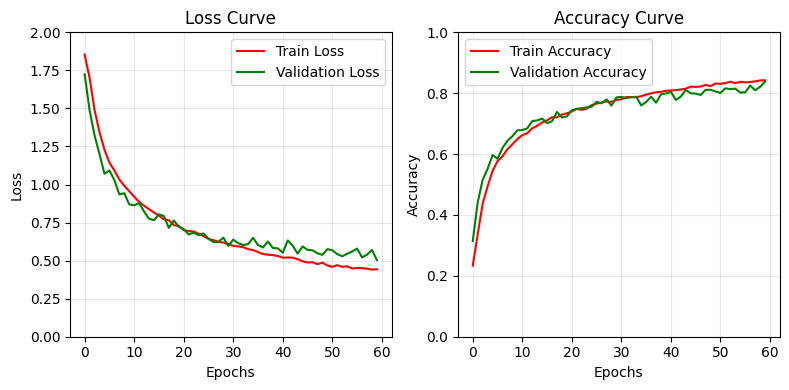

In [56]:
train_loss = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']
train_accuracy = CNN_History.history['accuracy']
val_accuracy = CNN_History.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss', color='red')
ax[0].plot(val_loss, label='Validation Loss', color='green')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy', color='red')
ax[1].plot(val_accuracy, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()

In [62]:

test_CNNresult = cnn_model.evaluate(test_images_CNNreshaped, Y_test_cat)


print("\nTest Loss: {:.2f}%".format(test_CNNresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_CNNresult[1] * 100))

192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.8313 - loss: 0.4953

Test Loss: 48.36%
Test Accuracy: 82.99%


In [58]:
# Predict on the test set
y_predCNN_prob = cnn_model.predict(test_images_CNNreshaped)  # Predict probabilities
y_predCNN = np.argmax(y_predCNN_prob, axis=1)   # Convert to class labels
y_true = np.argmax(Y_test_cat, axis=1)   # Convert one-hot encoded labels to class indices

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_predCNN, target_names=classes))

192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step
Classification Report:
              precision    recall  f1-score   support

    surprise       0.89      0.87      0.88       870
        fear       0.91      0.95      0.93       840
     disgust       0.74      0.83      0.78       910
       happy       0.89      0.84      0.86       887
         sad       0.78      0.74      0.76       865
       angry       0.89      0.90      0.90       859
     neutral       0.73      0.69      0.71       894

    accuracy                           0.83      6125
   macro avg       0.83      0.83      0.83      6125
weighted avg       0.83      0.83      0.83      6125



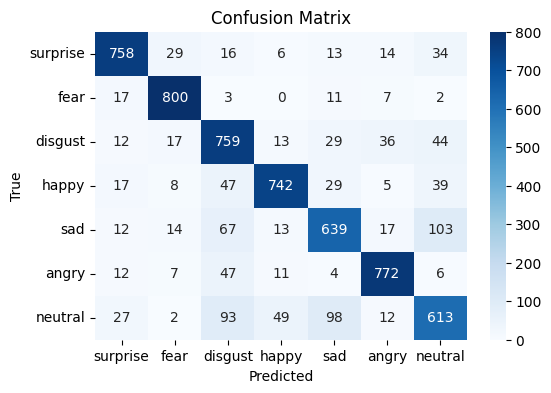

In [59]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_predCNN)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

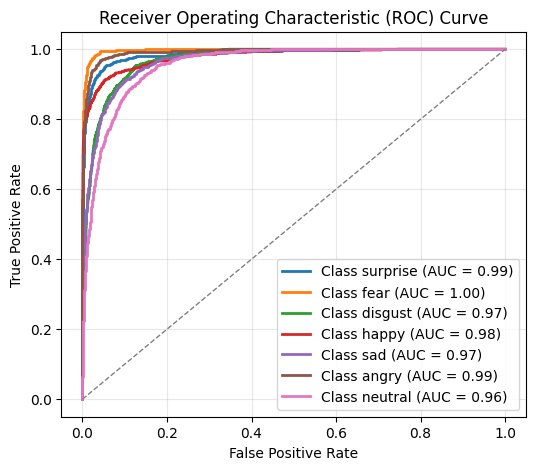

In [60]:
# Binarize the true labels for multi-class ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

# Initialisation des FPR, TPR, et AUC pour chaque classe
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_predCNN_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

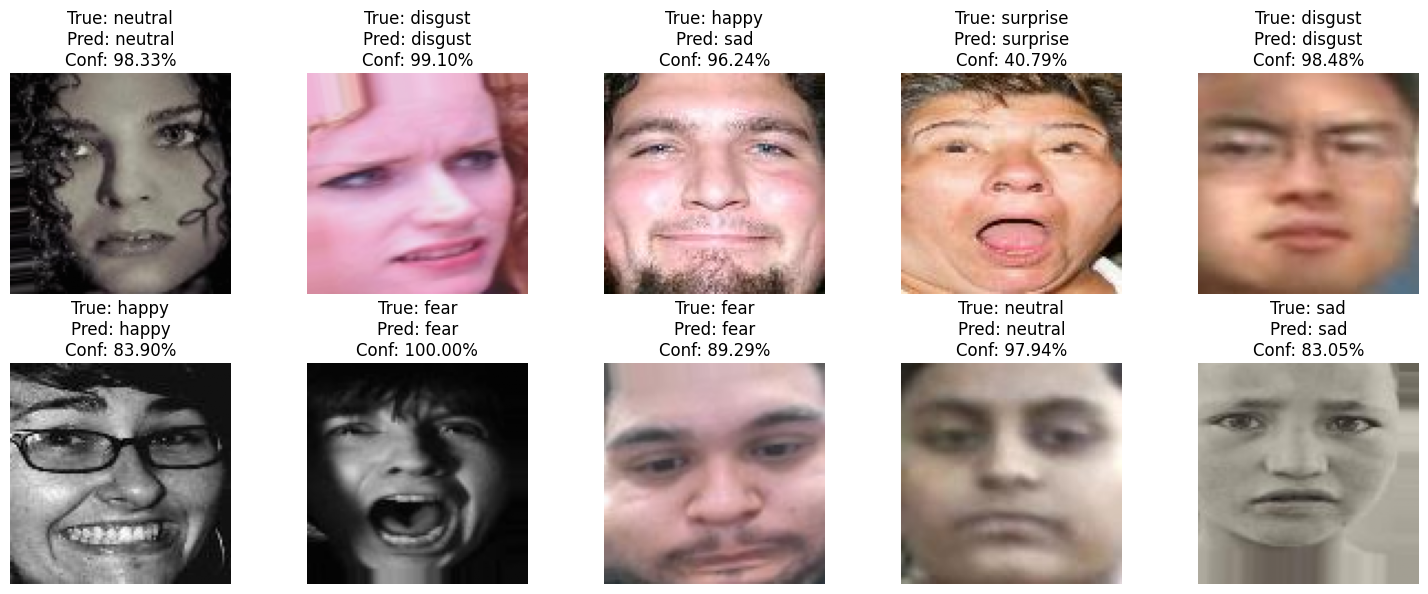

In [61]:
random_indices = np.random.choice(len(test_images_CNNreshaped), 10, replace=False)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    image = test_images_CNNreshaped[idx]
    true_class = classes[Y_test[idx] - 1]  
    pred_class = classes[y_predCNN[idx]]  
    confidence = np.max(y_predCNN_prob[idx]) * 100   
    
    # Plotting
    ax[i // 5, i % 5].imshow(image)
    ax[i // 5, i % 5].axis('off')  
    ax[i // 5, i % 5].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}%')

plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.models import load_model

model = load_model(r"C:\Users\Probook\Desktop\FER_RAF_DATASET\cnn_model.keras")  
print("Model loaded successfully!")


Model loaded successfully!


In [5]:
from tensorflow.keras.models import load_model

# Load the model from .keras file
model = load_model("cnn_model.keras")

# Save the model as .h5
model.save("cnn_model.h5")
